<a href="https://colab.research.google.com/github/stswee/ECE219/blob/main/ECE219_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [3]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [21]:
# Import libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from scipy.optimize import linear_sum_assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import umap


In [5]:
# plotmat.py code
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)

    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.3f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

# Part 1 - Clustering on Text Data

## Clustering with Sparse Text Representations

### Question 1

In [6]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_numbers(text = str) -> str:
  """
  Removes numbers from the text.

  Parameters
  ----------
  text : str
    The string to remove numbers from.

  Returns
  -------
  str
    The string with numbers removed.
  """

  # Remove numbers
  return re.sub(r'\b\d+\b', '', text)

def remove_punctuation(text = str) -> str:
  """
  Removes punctuation from the text.

  Parameters
  ----------
  text : str
    The string to remove punctuation from.

  Returns
  -------
  str
    The string with punctuation removed.
  """

  # Remove punctuation
  return re.sub(r'[^\w\s]', '', text)

def preprocessing(df = pd.DataFrame, preprocessing_functions = list) -> pd.DataFrame:
  """
  Preprocesses the text in the dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  preprocessing_functions : list
    The list of preprocessing functions to apply.

  Returns
  -------
  pd.DataFrame
    The preprocessed dataframe.
  """

  # Initialize dataframe
  df_copy = df.copy()

  # Apply preprocessing functions
  for preprocessing_function in preprocessing_functions:
    df_copy.map(preprocessing_function)

  return df_copy

In [7]:
# Select categories
cats = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
        'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Load in data (takes about 20 seconds)
newsgroups = fetch_20newsgroups(subset='all', categories = cats)
# newsgroups_train = fetch_20newsgroups(subset='train', categories = cats)
# newsgroups_test = fetch_20newsgroups(subset='test', categories = cats)

# Convert to pandas dataframe
newsgroups_df = pd.DataFrame(newsgroups.data, columns=['text'])
newsgroups_labels = newsgroups.target
# newsgroups_train_df = pd.DataFrame(newsgroups_train.data, columns = ['text'])
# newsgroups_train_df['target'] = newsgroups_train.target
# newsgroups_test_df = pd.DataFrame(newsgroups_test.data, columns = ['text'])
# newsgroups_test_df['target'] = newsgroups_test.target

# Preprocess labels (0 - 3 -> 0, 4 - 7 -> 1; let computers be the 0 label and rec be the 1 label)
newsgroups_labels = np.where(newsgroups_labels < 4, 0, 1)

# Perform preprocessing
preprocessing_functions = [clean, remove_numbers, remove_punctuation]
newsgroups_df = preprocessing(newsgroups_df, preprocessing_functions)
# newsgroups_train_df = preprocessing(newsgroups_train_df, preprocessing_functions)
# newsgroups_test_df = preprocessing(newsgroups_test_df, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_counts = count_vect.fit_transform(newsgroups_df['text'])
X_tfidf = tfidf_transformer.fit_transform(X_counts)
# X_train_counts = count_vect.fit_transform(newsgroups_train_df['text'])
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_counts = count_vect.transform(newsgroups_test_df['text'])
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Report shape of TF-IDF matrices
print("Shape of X_tfidf:", X_tfidf.shape)
# print("Shape of X_train_tfidf:", X_train_tfidf.shape)
# print("Shape of X_test_tfidf:", X_test_tfidf.shape)

# TODO: Check if headers/footers removed and whether to use entire newsgroup dataset

Shape of X_tfidf: (7882, 27768)


### Question 2

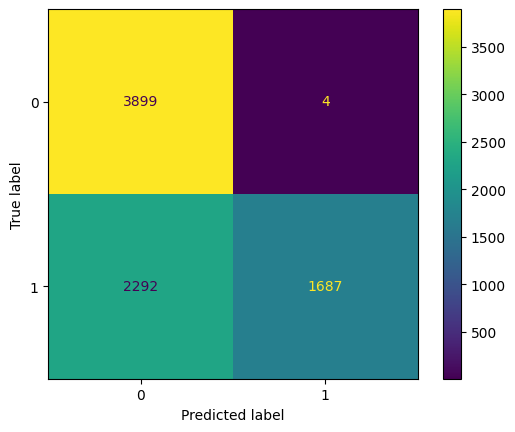

In [8]:
# Apply K-means clustering
# Create model (takes about 10 seconds to fit with these configurations)
kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 10000, n_init = 50)

# Fit model to data
kmeans.fit(X_tfidf)

# Get labels for each data point
labels = kmeans.labels_

# Create confusion matrix (0 = computers, 1 = rec)
cm = confusion_matrix(newsgroups_labels, labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = set(kmeans.labels_))
disp.plot()
plt.show()

### Question 3

In [9]:
# Calculate homogeneity
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
print("Homogeneity:", homogeneity)

# Calculate completeness
completeness = metrics.completeness_score(newsgroups_labels, labels)
print("Completeness:", completeness)

# Calculate V-measure
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
print("V-measure:", v_measure)

# Calculate Adjusted Rand Index
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
print("Adjusted Rand Index:", ari)

# Calculate Adjusted Mutual Information
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)
print("Adjusted Mutual Information:", ami)

Homogeneity: 0.24794628349395062
Completeness: 0.33054175148611625
V-measure: 0.28334760224863614
Adjusted Rand Index: 0.1741327386002284
Adjusted Mutual Information: 0.28327261469368775


## Clustering with Dense Text Representations

### Question 4

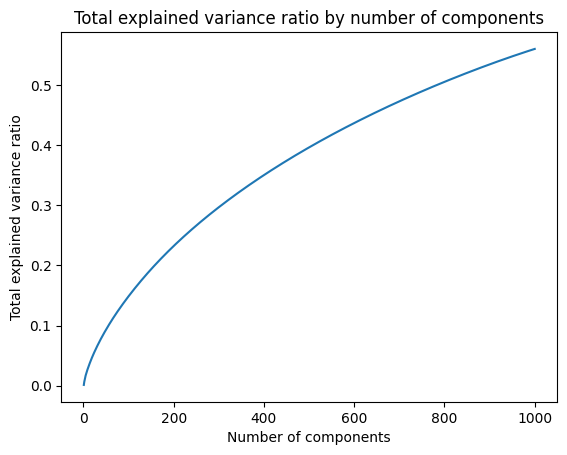

In [10]:
# Experiment with different explained variance ratios
# Calculate r = 1000 components first, then subtract 1 for r = 999, 998, ..., 1
# Takes about a minute to run
r = 1000
svd = TruncatedSVD(n_components = r)
lsa_matrix = svd.fit_transform(X_tfidf)
explained_variance_ratio = svd.explained_variance_ratio_
total_explained_variance = []
for i in range(1000):
  total_explained_variance.append(sum(explained_variance_ratio[:i+1]))

# Plot
plt.plot(range(1, 1001), total_explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance ratio')
plt.title('Total explained variance ratio by number of components')
plt.show()

### Question 5

In [11]:
# Number of components
comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# SVD/NMF
model = ['svd', 'nmf']

# Create tuples for SVD/NMF and number of components to be used as keys
parameters = [(model, r) for model in model for r in comps]

# Initialize list to store metrics
homogeneity_metrics = []
completeness_metrics = []
v_measure_metrics = []
ari_metrics = []
ami_metrics = []

# Create model
# Can modify configurations as needed; max_iter and n_init minimized for speed
kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 1000, n_init = 30)

# Perform dimensionality reduction and clustering, then retrieve metrics
# About 6 minutes to run
for parameter in parameters:

  # Get model and number of components
  model, r = parameter

  # SVD
  if model == 'svd':
    svd = TruncatedSVD(n_components = r)
    lsa_matrix = svd.fit_transform(X_tfidf)

    # Fit
    kmeans.fit(lsa_matrix)

    # Get labels for each data point
    labels = kmeans.labels_

    # Calculate metrics
    homogeneity_metrics.append(metrics.homogeneity_score(newsgroups_labels, labels))
    completeness_metrics.append(metrics.completeness_score(newsgroups_labels, labels))
    v_measure_metrics.append(metrics.v_measure_score(newsgroups_labels, labels))
    ari_metrics.append(metrics.adjusted_rand_score(newsgroups_labels, labels))
    ami_metrics.append(metrics.adjusted_mutual_info_score(newsgroups_labels, labels))

  # NMF
  # Question to ask TA: If NMR for r = 300 takes too long to converge, can we ignore?
  # r = 300 takes a long time to converge, so ignore
  elif model == 'nmf' and r == 300:
    # Assign metrics to zero
    homogeneity_metrics.append(0)
    completeness_metrics.append(0)
    v_measure_metrics.append(0)
    ari_metrics.append(0)
    ami_metrics.append(0)

  elif model == 'nmf':
    nmf = NMF(n_components = r, init = 'random', random_state = 0)
    nmf_matrix = nmf.fit_transform(X_tfidf)

    # fit
    kmeans.fit(nmf_matrix)

    # Get labels for each data point
    labels = kmeans.labels_

    # Calculate metrics
    homogeneity_metrics.append(metrics.homogeneity_score(newsgroups_labels, labels))
    completeness_metrics.append(metrics.completeness_score(newsgroups_labels, labels))
    v_measure_metrics.append(metrics.v_measure_score(newsgroups_labels, labels))
    ari_metrics.append(metrics.adjusted_rand_score(newsgroups_labels, labels))
    ami_metrics.append(metrics.adjusted_mutual_info_score(newsgroups_labels, labels))

# Put data into pandas dataframe
metrics_df = pd.DataFrame({'Model': [parameter[0] for parameter in parameters],
                           'Number of components': [parameter[1] for parameter in parameters],
                           'Homogeneity': homogeneity_metrics,
                           'Completeness': completeness_metrics,
                           'V-measure': v_measure_metrics,
                           'Adjusted Rand Index': ari_metrics,
                           'Adjusted Mutual Information': ami_metrics})

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [12]:
metrics_df

,Model,Number of components,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information
0,svd,1,0.000284,0.000289,0.000286,0.000317,0.000194
1,svd,2,0.575104,0.577939,0.576518,0.670022,0.576479
2,svd,3,0.407430,0.444287,0.425061,0.404592,0.425006
3,svd,4,0.231308,0.312261,0.265756,0.162267,0.265679
4,svd,5,0.220127,0.308775,0.257022,0.143420,0.256942
5,svd,6,0.222218,0.310361,0.258995,0.145737,0.258916
6,svd,7,0.224073,0.312504,0.261002,0.146902,0.260923
7,svd,8,0.232851,0.319883,0.269515,0.155789,0.269438
8,svd,9,0.231789,0.319084,0.268520,0.154589,0.268442
9,svd,10,0.233028,0.320017,0.269681,0.155989,0.269604


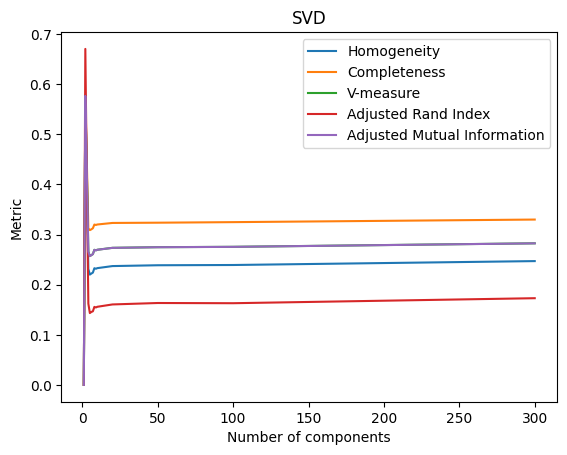

In [13]:
# Get SVD rows and plot number of components vs. each metric
svd_df = metrics_df[metrics_df['Model'] == 'svd']

# Plot number of components vs metric
plt.plot(svd_df['Number of components'], svd_df['Homogeneity'], label = 'Homogeneity')
plt.plot(svd_df['Number of components'], svd_df['Completeness'], label = 'Completeness')
plt.plot(svd_df['Number of components'], svd_df['V-measure'], label = 'V-measure')
plt.plot(svd_df['Number of components'], svd_df['Adjusted Rand Index'], label = 'Adjusted Rand Index')
plt.plot(svd_df['Number of components'], svd_df['Adjusted Mutual Information'], label = 'Adjusted Mutual Information')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.title('SVD')
plt.legend()
plt.show()

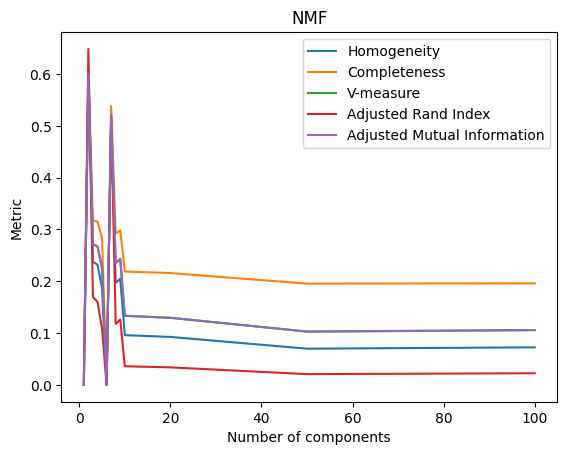

In [14]:
# Get NMF rows and plot number of components vs. each metric
nmf_df = metrics_df[metrics_df['Model'] == 'nmf']

# Exclude 300 components
nmf_df = nmf_df[nmf_df['Number of components'] != 300]

# Plot number of components vs metric
plt.plot(nmf_df['Number of components'], nmf_df['Homogeneity'], label = 'Homogeneity')
plt.plot(nmf_df['Number of components'], nmf_df['Completeness'], label = 'Completeness')
plt.plot(nmf_df['Number of components'], nmf_df['V-measure'], label = 'V-measure')
plt.plot(nmf_df['Number of components'], nmf_df['Adjusted Rand Index'], label = 'Adjusted Rand Index')
plt.plot(nmf_df['Number of components'], nmf_df['Adjusted Mutual Information'], label = 'Adjusted Mutual Information')
plt.xlabel('Number of components')
plt.ylabel('Metric')
plt.title('NMF')
plt.legend()

Visually, the optimal model has r = 2 for both SVD and NMR. The metrics dataframe also supports this.

### Question 6

TODO

### Question 7

Using SVD, using 2 or 3 components yielded better performance. Using more components (r >= 4) led to comparable performance.

Using NMF, using 2 components yielded better formance. Using 3 or 4 components led to comparable performance. Using more components (r >= 5) led to worse performance.

For both methods, using r = 1 led to the worst performance. This is expected as we seek to create two clusters.

### Question 8

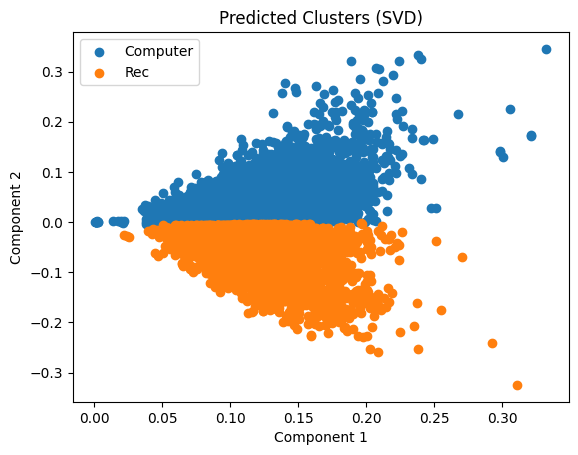

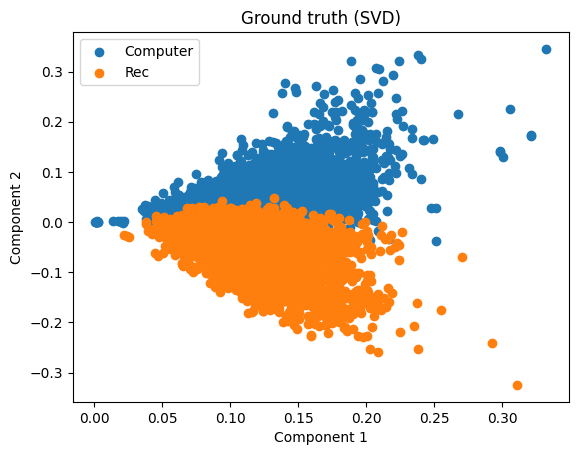

In [15]:
# Use r = 2 components based on results from Question 5
r = 2

# SVD
svd = TruncatedSVD(n_components = r)
lsa_matrix = svd.fit_transform(X_tfidf)

# Fit
kmeans.fit(lsa_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Visualize clusters
lsa_2d = lsa_matrix[:, :2] # Get top two components

# Put top two components and label in dataframe
lsa_df = pd.DataFrame(lsa_2d, columns = ['Component 1', 'Component 2'])
lsa_df['Label'] = labels
lsa_df['Ground truth'] = newsgroups_labels

# Plot results
plt.scatter(lsa_df[lsa_df['Label'] == 0]['Component 1'], lsa_df[lsa_df['Label'] == 0]['Component 2'], label = 'Computer')
plt.scatter(lsa_df[lsa_df['Label'] == 1]['Component 1'], lsa_df[lsa_df['Label'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Predicted Clusters (SVD)')
plt.legend()
plt.show()

# Plot ground truth
plt.scatter(lsa_df[lsa_df['Ground truth'] == 0]['Component 1'], lsa_df[lsa_df['Ground truth'] == 0]['Component 2'], label = 'Computer')
plt.scatter(lsa_df[lsa_df['Ground truth'] == 1]['Component 1'], lsa_df[lsa_df['Ground truth'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Ground truth (SVD)')
plt.legend()
plt.show()


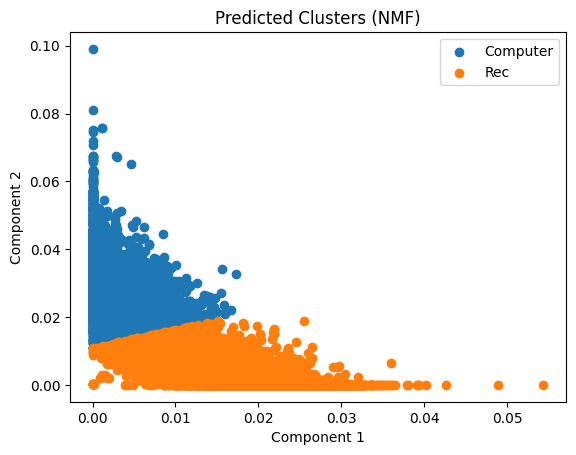

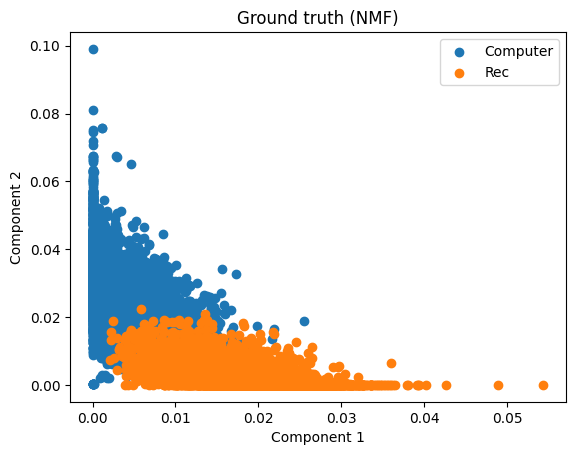

In [16]:
# Use r = 2 components based on results from Question 5
r = 2

# NMF
nmf = NMF(n_components = r, init = 'random', random_state = 0)
nmf_matrix = nmf.fit_transform(X_tfidf)

# Fit
kmeans.fit(nmf_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Visualize clusters
nmf_2d = nmf_matrix[:, :2] # Get top two components

# Put top two components and label in dataframe
nmf_df = pd.DataFrame(nmf_2d, columns = ['Component 1', 'Component 2'])
nmf_df['Label'] = labels
nmf_df['Ground truth'] = newsgroups_labels

# Plot results
plt.scatter(nmf_df[nmf_df['Label'] == 0]['Component 1'], nmf_df[nmf_df['Label'] == 0]['Component 2'], label = 'Computer')
plt.scatter(nmf_df[nmf_df['Label'] == 1]['Component 1'], nmf_df[nmf_df['Label'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Predicted Clusters (NMF)')
plt.legend()
plt.show()

# Plot ground truth
plt.scatter(nmf_df[nmf_df['Ground truth'] == 0]['Component 1'], nmf_df[nmf_df['Ground truth'] == 0]['Component 2'], label = 'Computer')
plt.scatter(nmf_df[nmf_df['Ground truth'] == 1]['Component 1'], nmf_df[nmf_df['Ground truth'] == 1]['Component 2'], label = 'Rec')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Ground truth (NMF)')
plt.legend()
plt.show()

### Question 9

TODO

### Question 10

In [17]:
# Load in all categories
newsgroups = fetch_20newsgroups(subset='all')
newsgroups_df = pd.DataFrame(newsgroups.data, columns=['text'])
# Ground truth labels
newsgroups_labels = newsgroups.target

# Dataset preprocessing
preprocessing_functions = [clean, remove_numbers, remove_punctuation]
newsgroups_df = preprocessing(newsgroups_df, preprocessing_functions)

# Initialize CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
tfidf_transformer = TfidfTransformer()

# Remove stopwords and convert to TF-IDF matrix
X_counts = count_vect.fit_transform(newsgroups_df['text'])
X_tfidf = tfidf_transformer.fit_transform(X_counts)

SVD Metrics:
Homogeneity: 0.2842046452871437
Completeness: 0.3779420522023778
V-measure: 0.3244383375844648
Adjusted Rand Index: 0.09146705887488607
Adjusted Mutual Information: 0.3219128871356232

SVD Confusion Matrix:


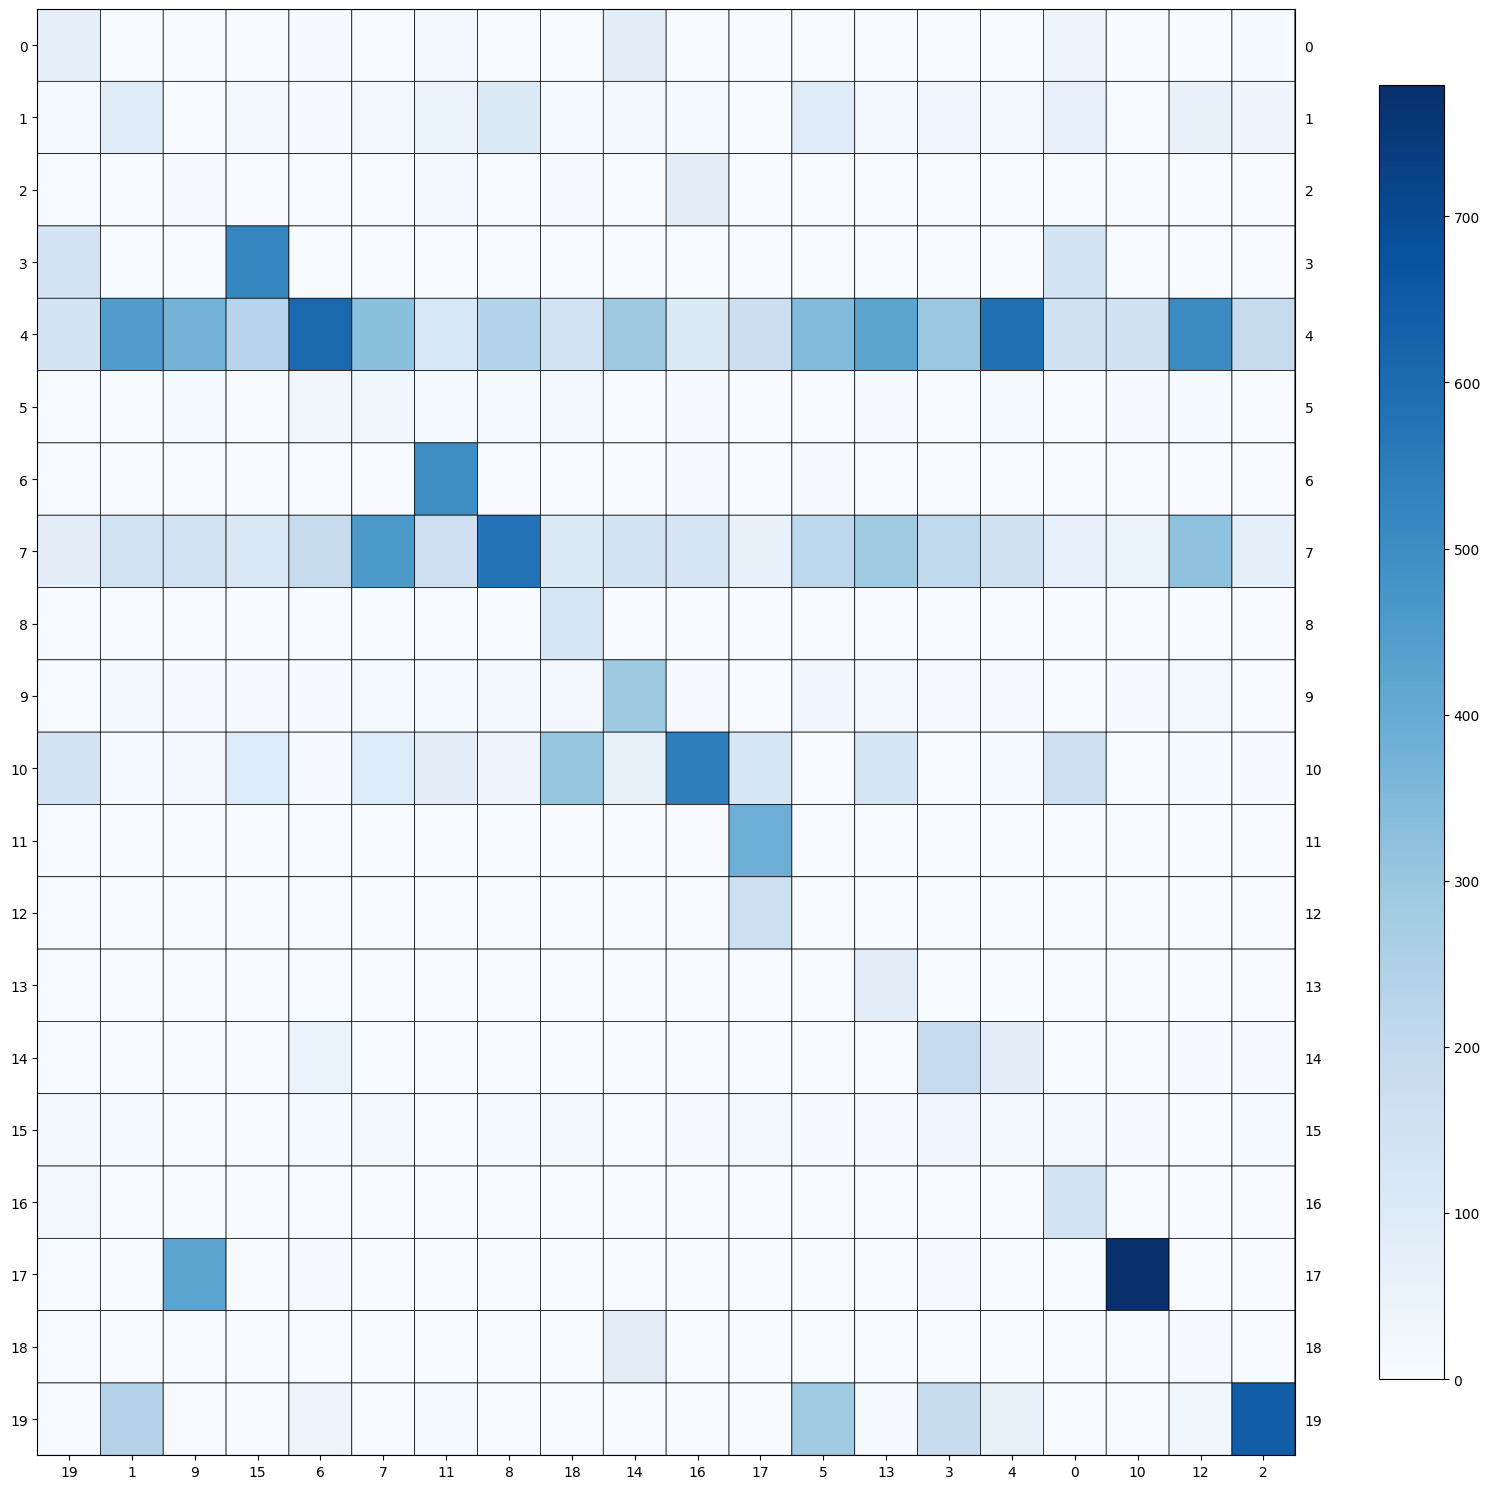


NMF Metrics:
Homogeneity: 0.263601897917881
Completeness: 0.33219506685547967
V-measure: 0.2939499704748315
Adjusted Rand Index: 0.0905563760523189
Adjusted Mutual Information: 0.2913656471111346

NMF Confusion Matrix:


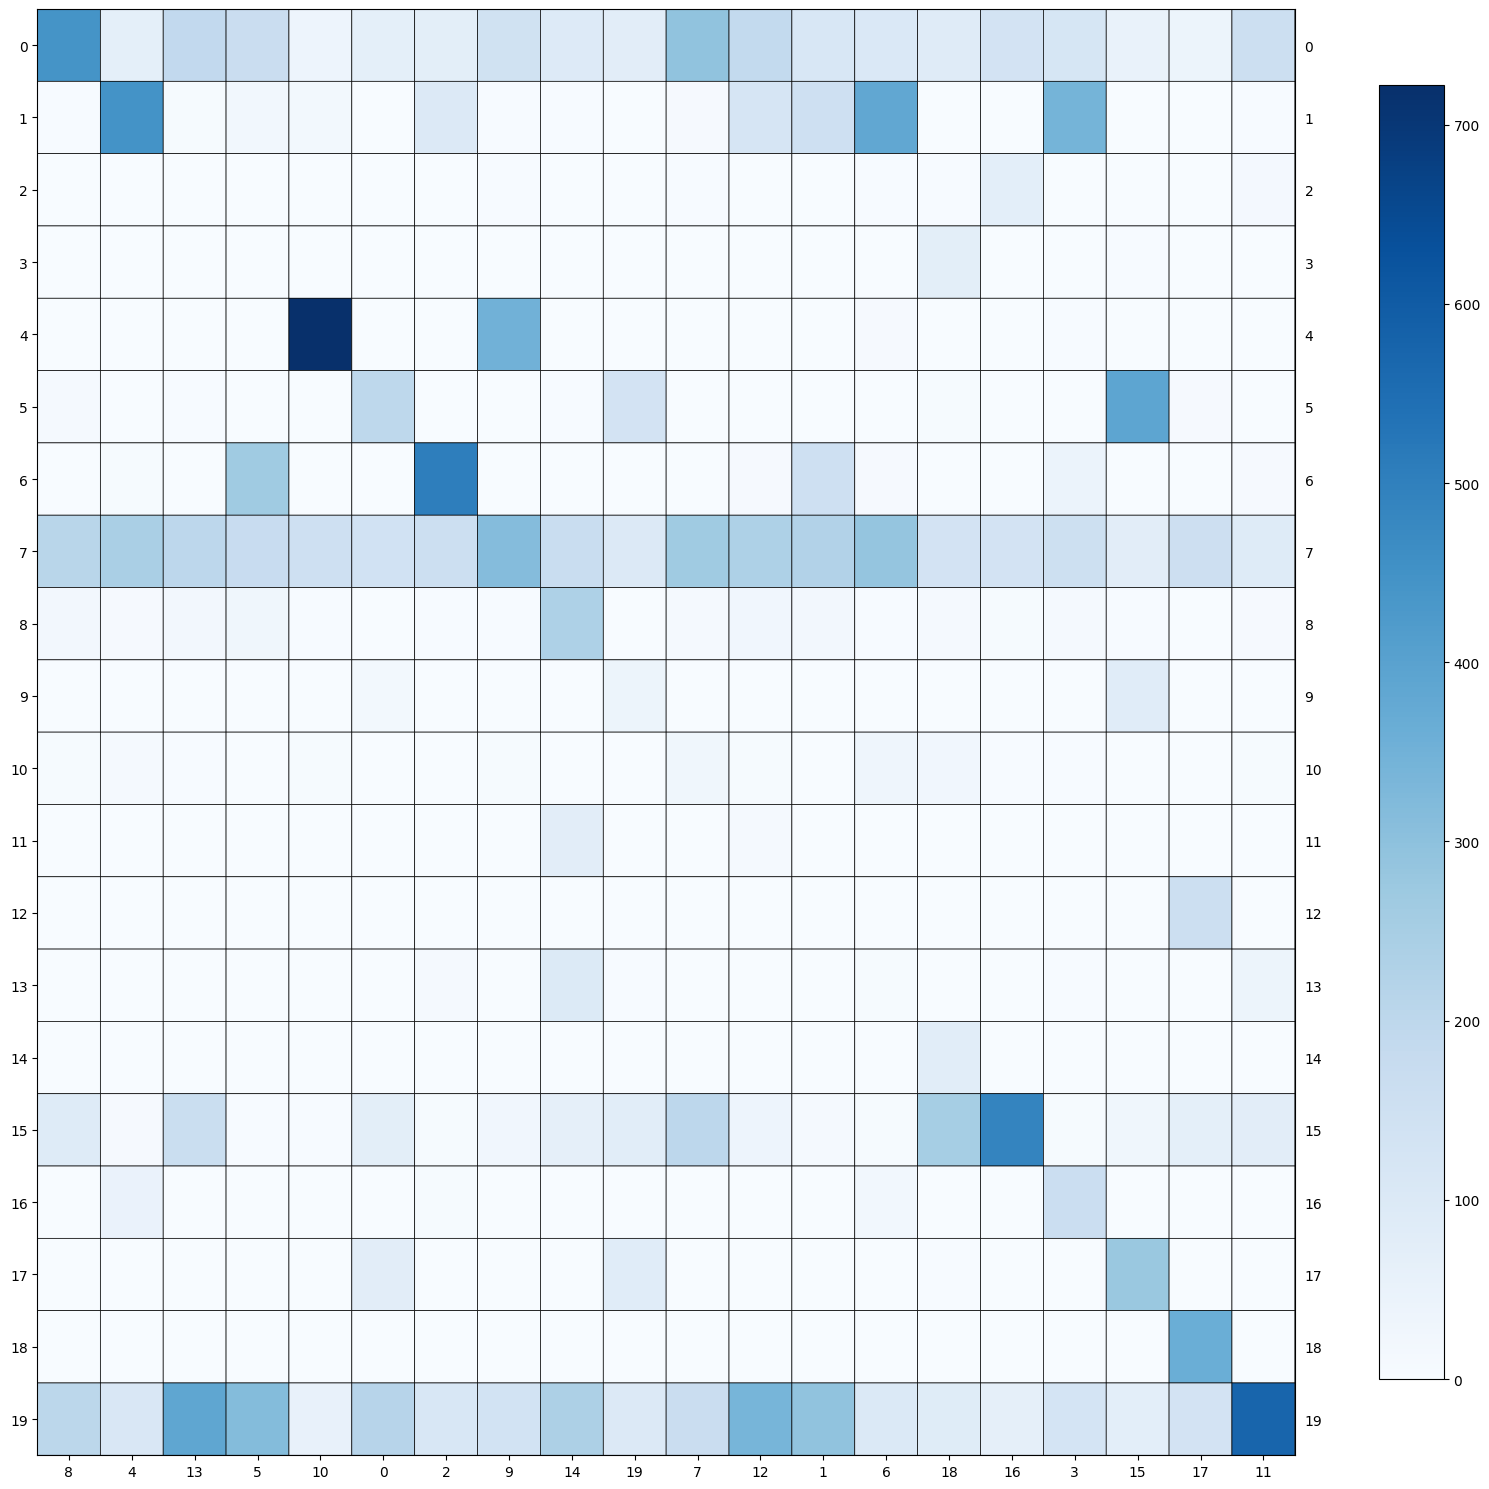

In [18]:
# Use heuristic that the number of components should match the number of classes
# Takes about a minute to run, most of the time in nmf
r = 20
kmeans = KMeans(n_clusters = 20, random_state = 0)

# SVD
svd = TruncatedSVD(n_components = r)
lsa_matrix = svd.fit_transform(X_tfidf)

# Fit
kmeans.fit(lsa_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Get metrics
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
completeness = metrics.completeness_score(newsgroups_labels, labels)
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

# Print metrics
print("SVD Metrics:")
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)
print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)
print()

# Plot confusion matrix
print("SVD Confusion Matrix:")
cm = confusion_matrix(labels, newsgroups_labels)
rows, cols = linear_sum_assignment(cm, maximize = True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels = cols, yticklabels = rows, size = (15, 15), if_show_values = False)
print()

# NMF
nmf = NMF(n_components = r, init = 'random', random_state = 0)
nmf_matrix = nmf.fit_transform(X_tfidf)

# Fit
kmeans.fit(nmf_matrix)

# Get labels for each data point
labels = kmeans.labels_

# Get metrics
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
completeness = metrics.completeness_score(newsgroups_labels, labels)
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

# Print metrics
print("NMF Metrics:")
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)
print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)
print()

# Plot confusion matrix
print("NMF Confusion Matrix:")
cm = confusion_matrix(labels, newsgroups_labels)
rows, cols = linear_sum_assignment(cm, maximize = True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels = cols, yticklabels = rows, size = (15, 15), if_show_values = False)
print()

# TODO: Debug if_show_values portion of plot_mat with TA?

### Question 11

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 5 , metric = cosine
Homogeneity: 0.4898104305448755
Completeness: 0.5074072093546976
V-measure: 0.498453564661426
Adjusted Rand Index: 0.39661265471467894
Adjusted Mutual Information: 0.4967910973916662
Confusion Matrix for r = 5  and metric = cosine


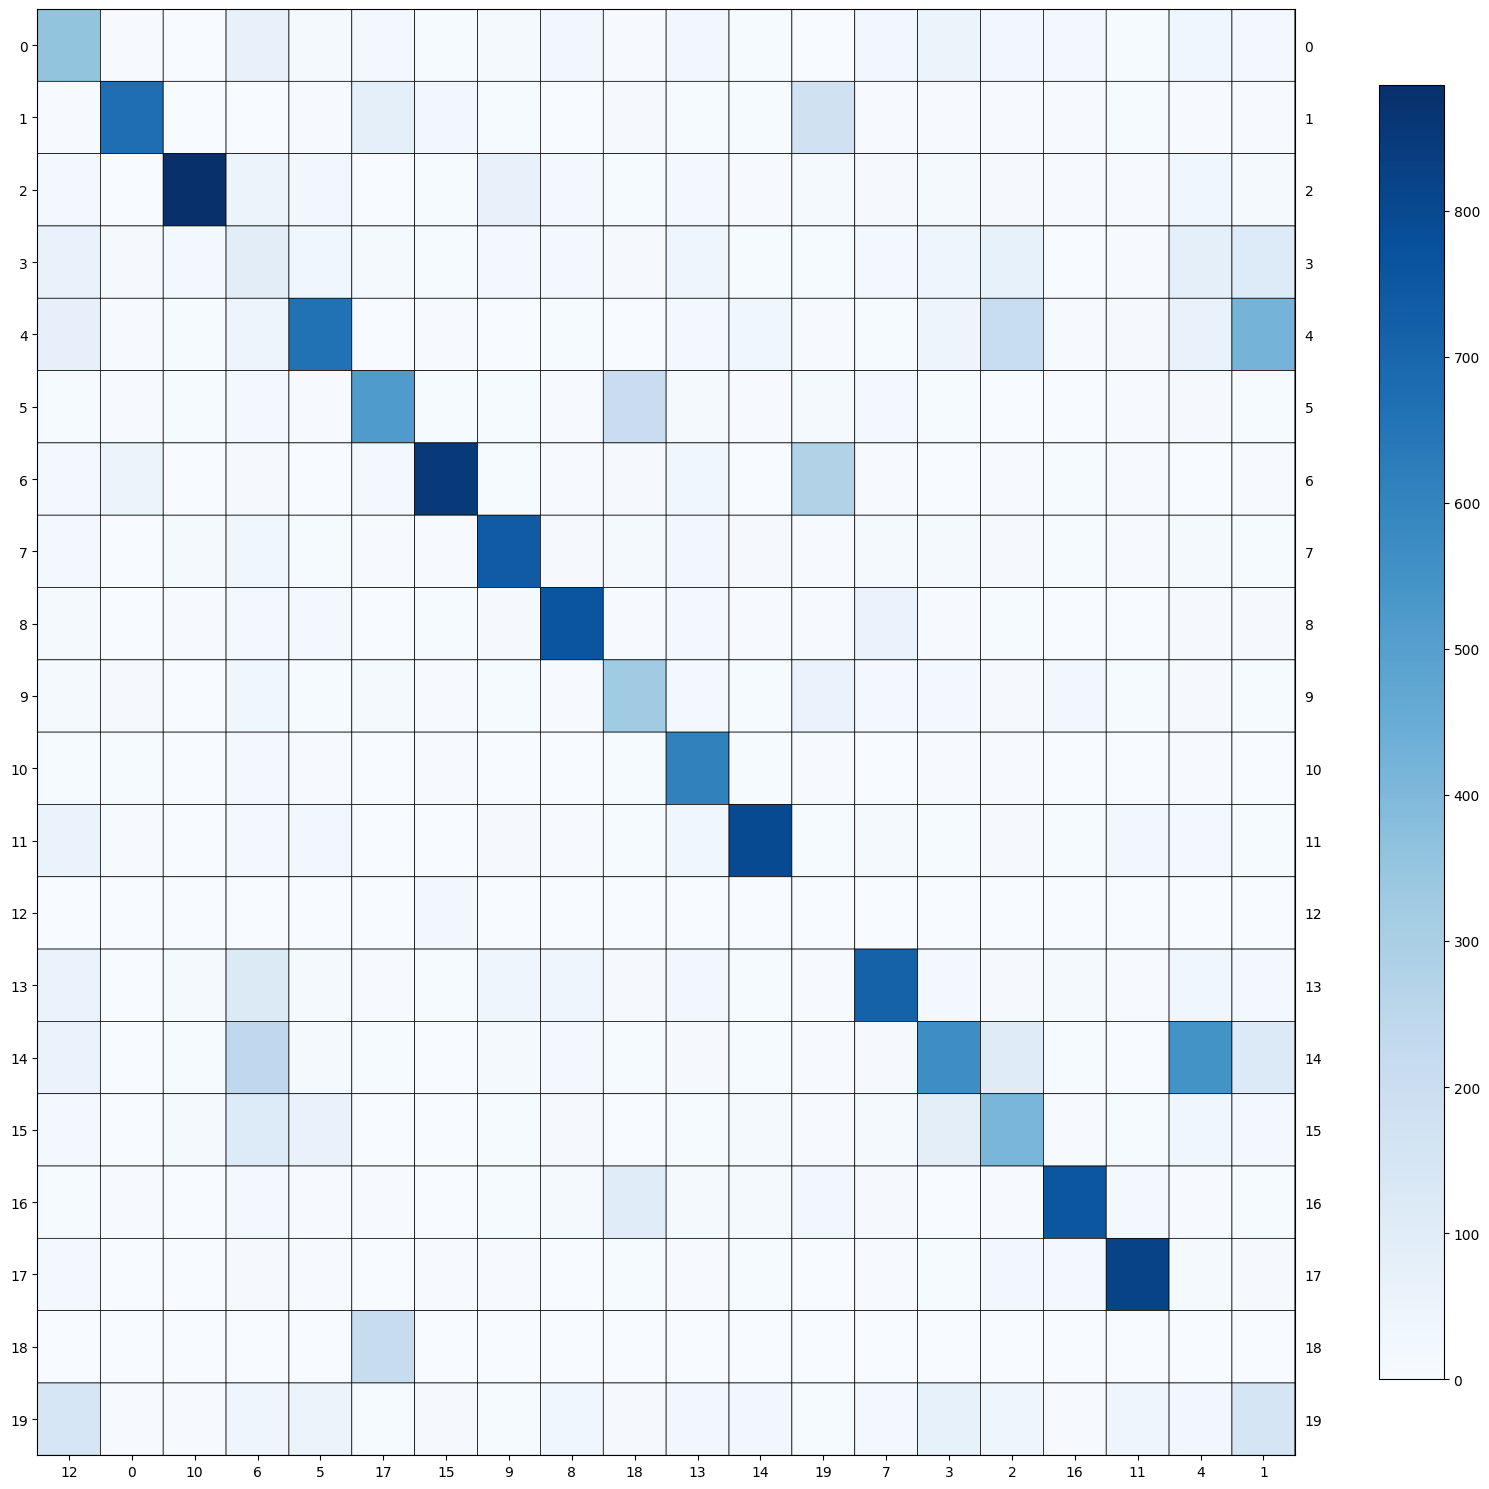

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 5 , metric = euclidean
Homogeneity: 0.5086156956892214
Completeness: 0.5295864984544819
V-measure: 0.5188893008672683
Adjusted Rand Index: 0.4131315718371751
Adjusted Mutual Information: 0.5172901204039637
Confusion Matrix for r = 5  and metric = euclidean


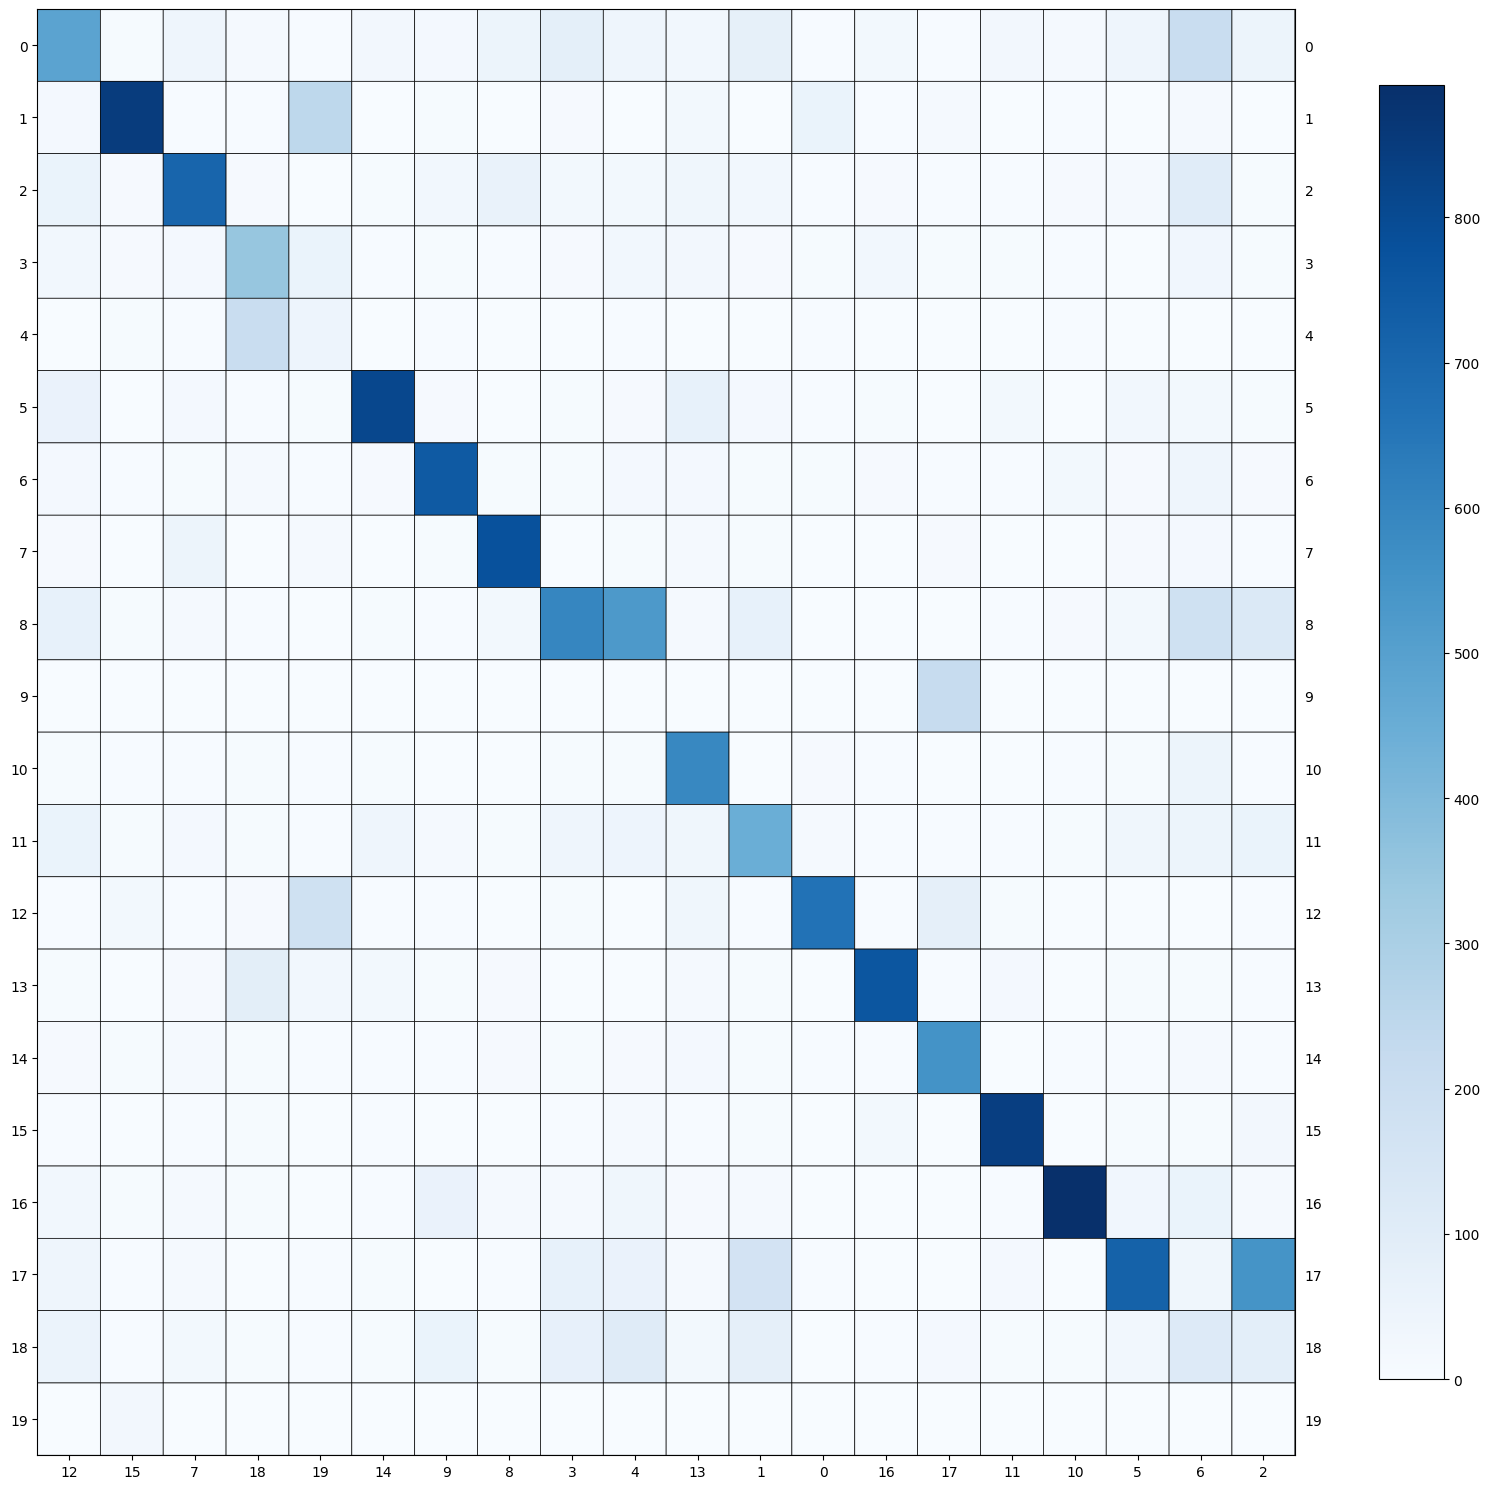

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 20 , metric = cosine
Homogeneity: 0.5002640188736065
Completeness: 0.5255618606009194
V-measure: 0.5126010053198996
Adjusted Rand Index: 0.40399059158106715
Adjusted Mutual Information: 0.510972411345321
Confusion Matrix for r = 20  and metric = cosine


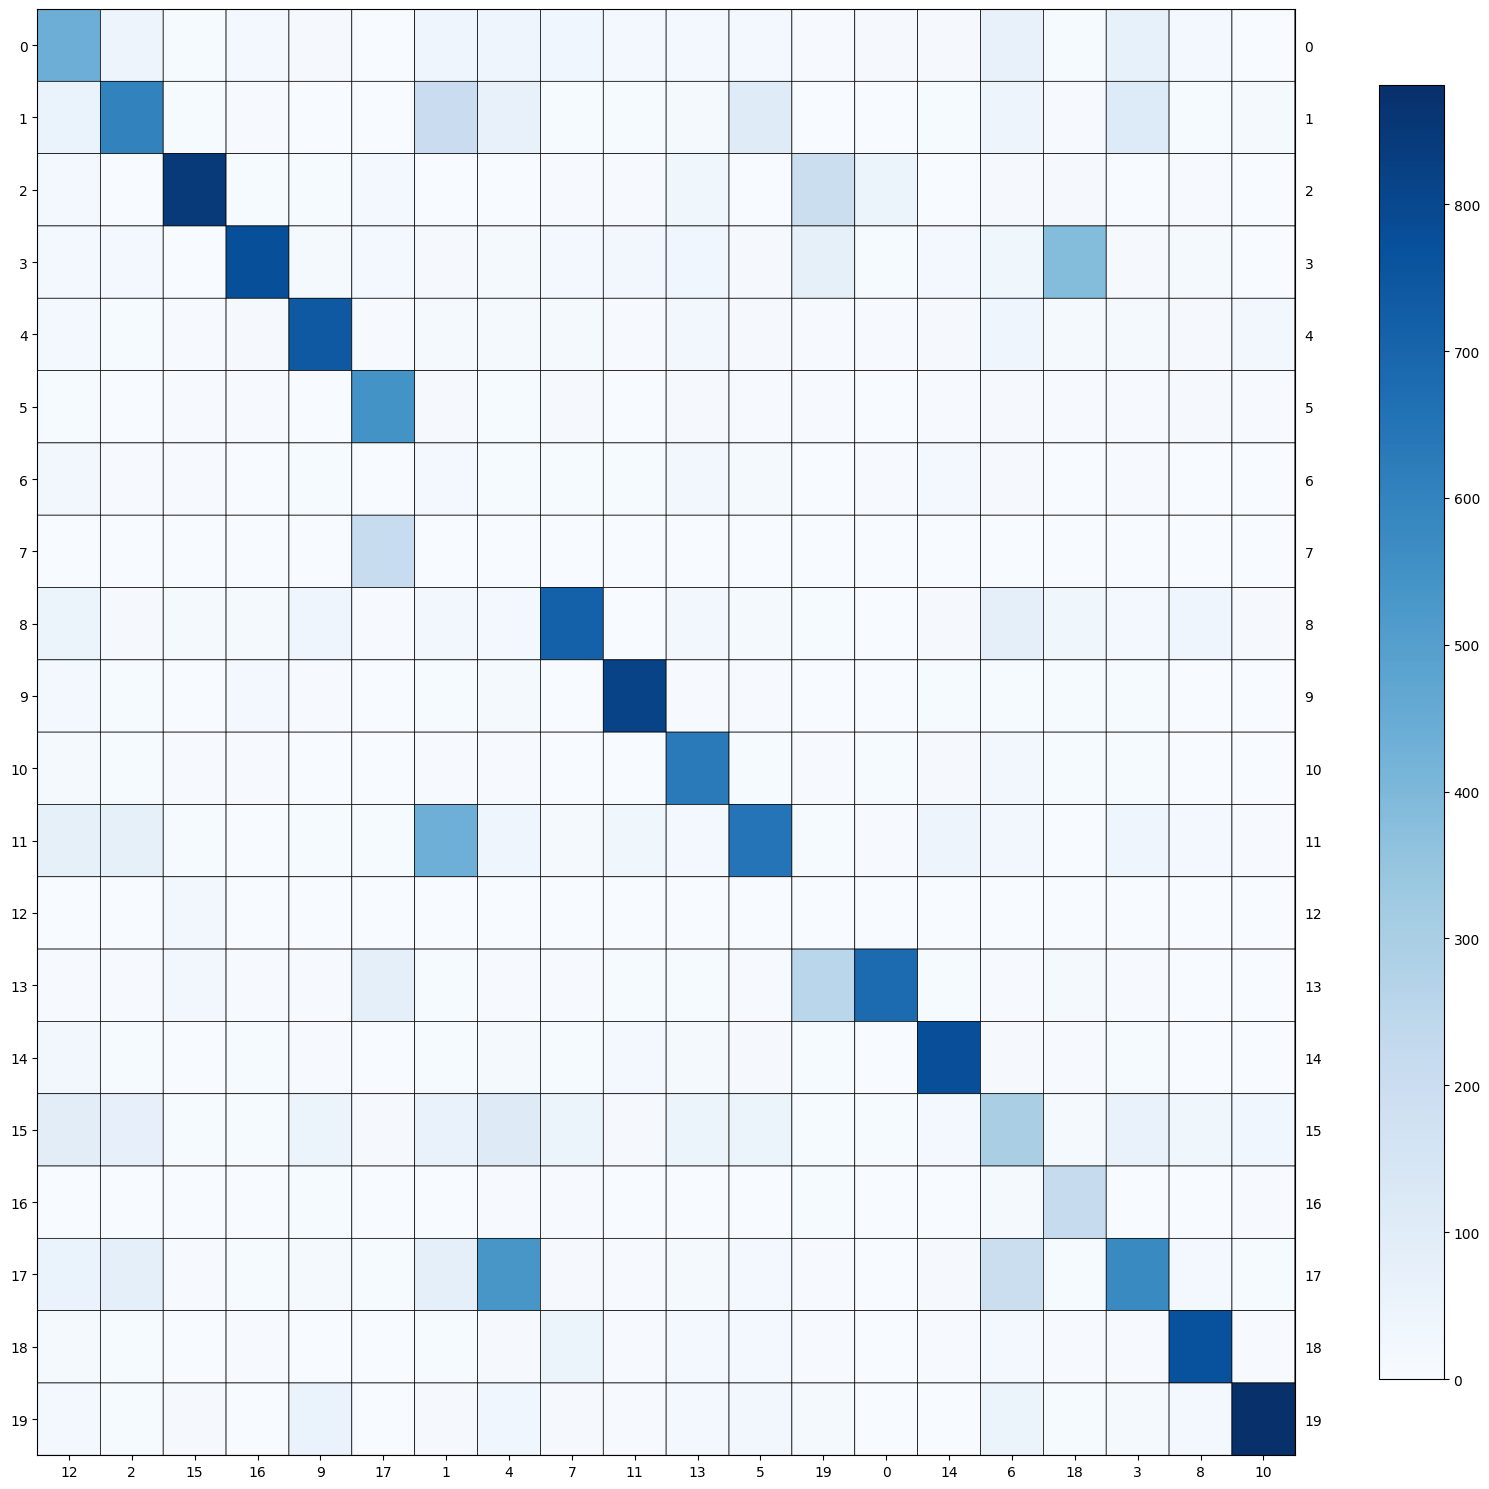

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 20 , metric = euclidean
Homogeneity: 0.5036103633944251
Completeness: 0.5365529051458758
V-measure: 0.5195599800789922
Adjusted Rand Index: 0.395621841697206
Adjusted Mutual Information: 0.5179362176751446
Confusion Matrix for r = 20  and metric = euclidean


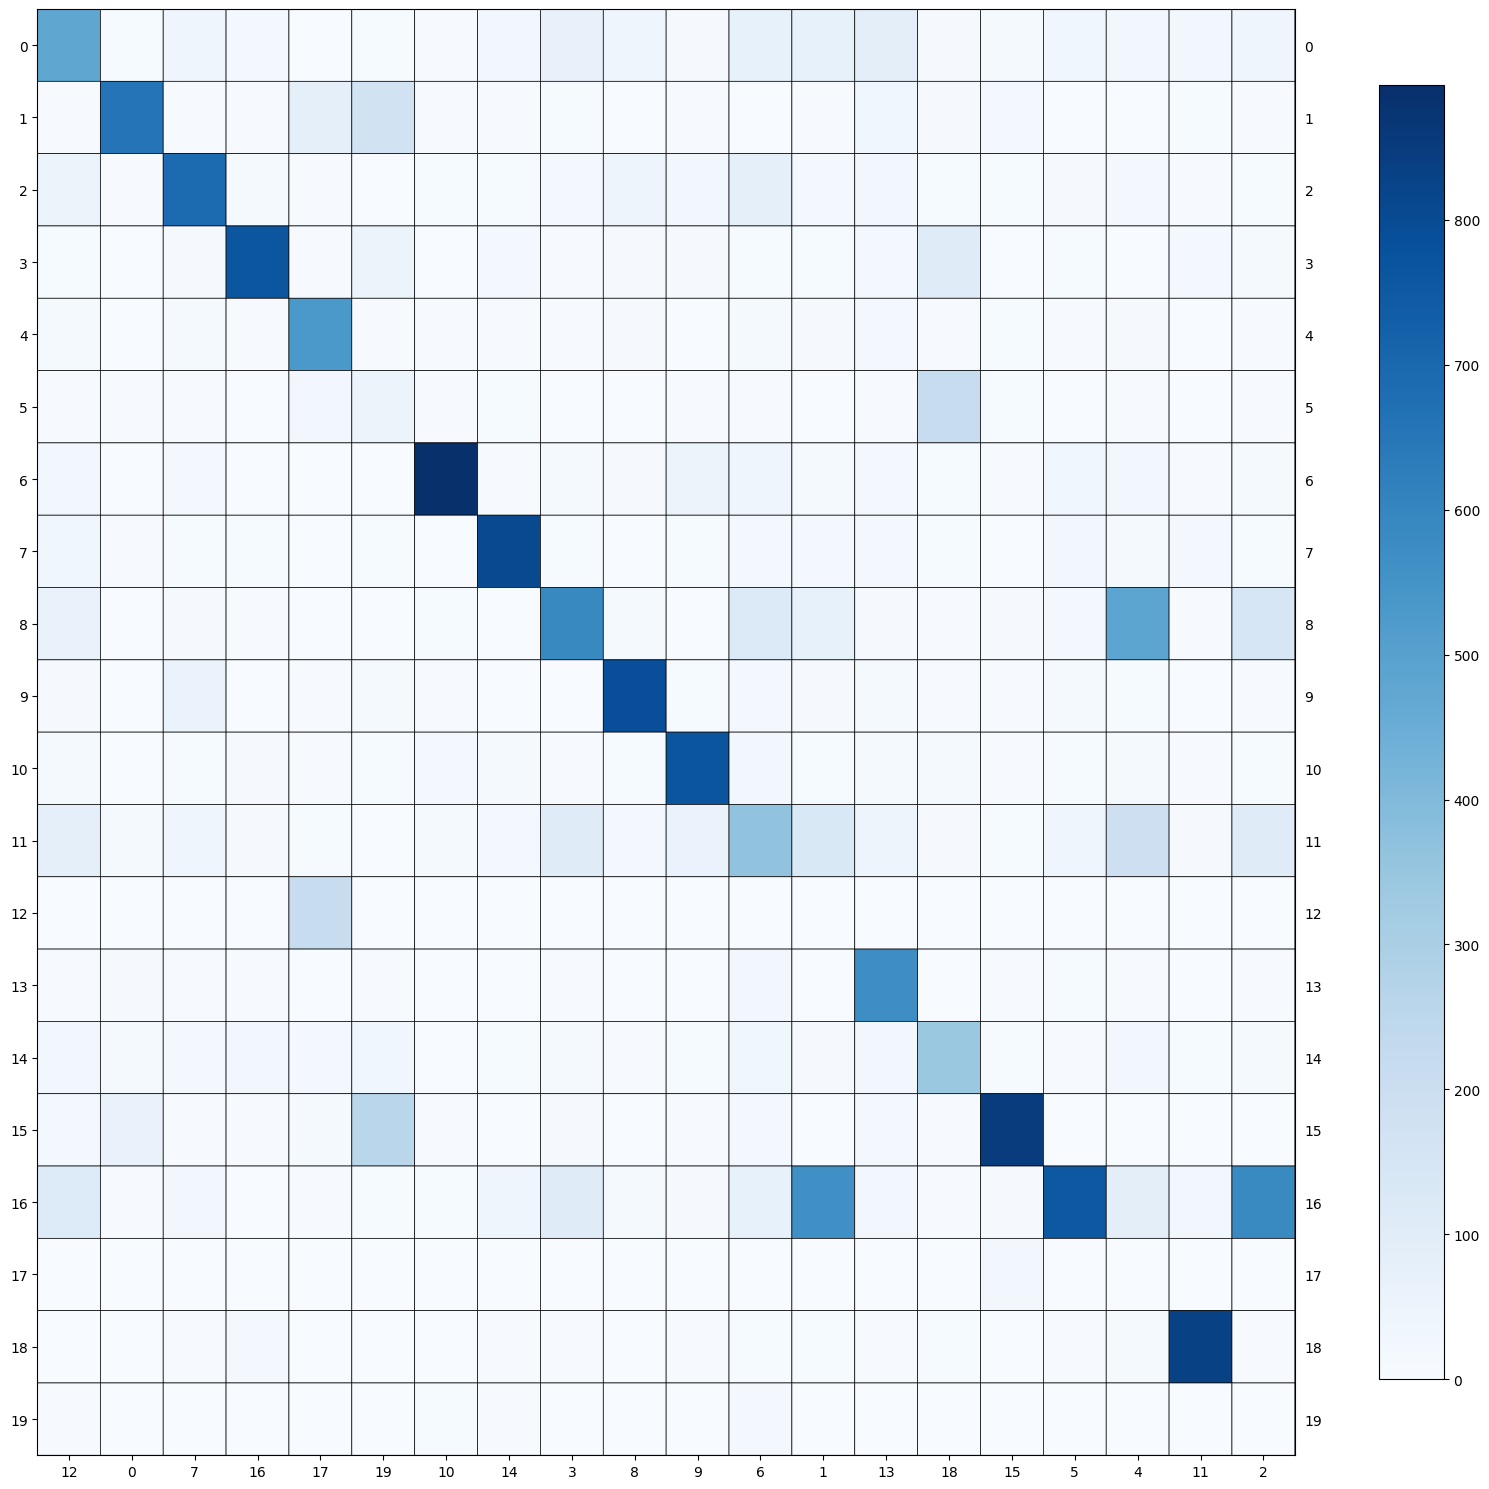

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 200 , metric = cosine
Homogeneity: 0.4860756831191666
Completeness: 0.5171767766773678
V-measure: 0.5011441588048596
Adjusted Rand Index: 0.3771646705906657
Adjusted Mutual Information: 0.49946736299412625
Confusion Matrix for r = 200  and metric = cosine


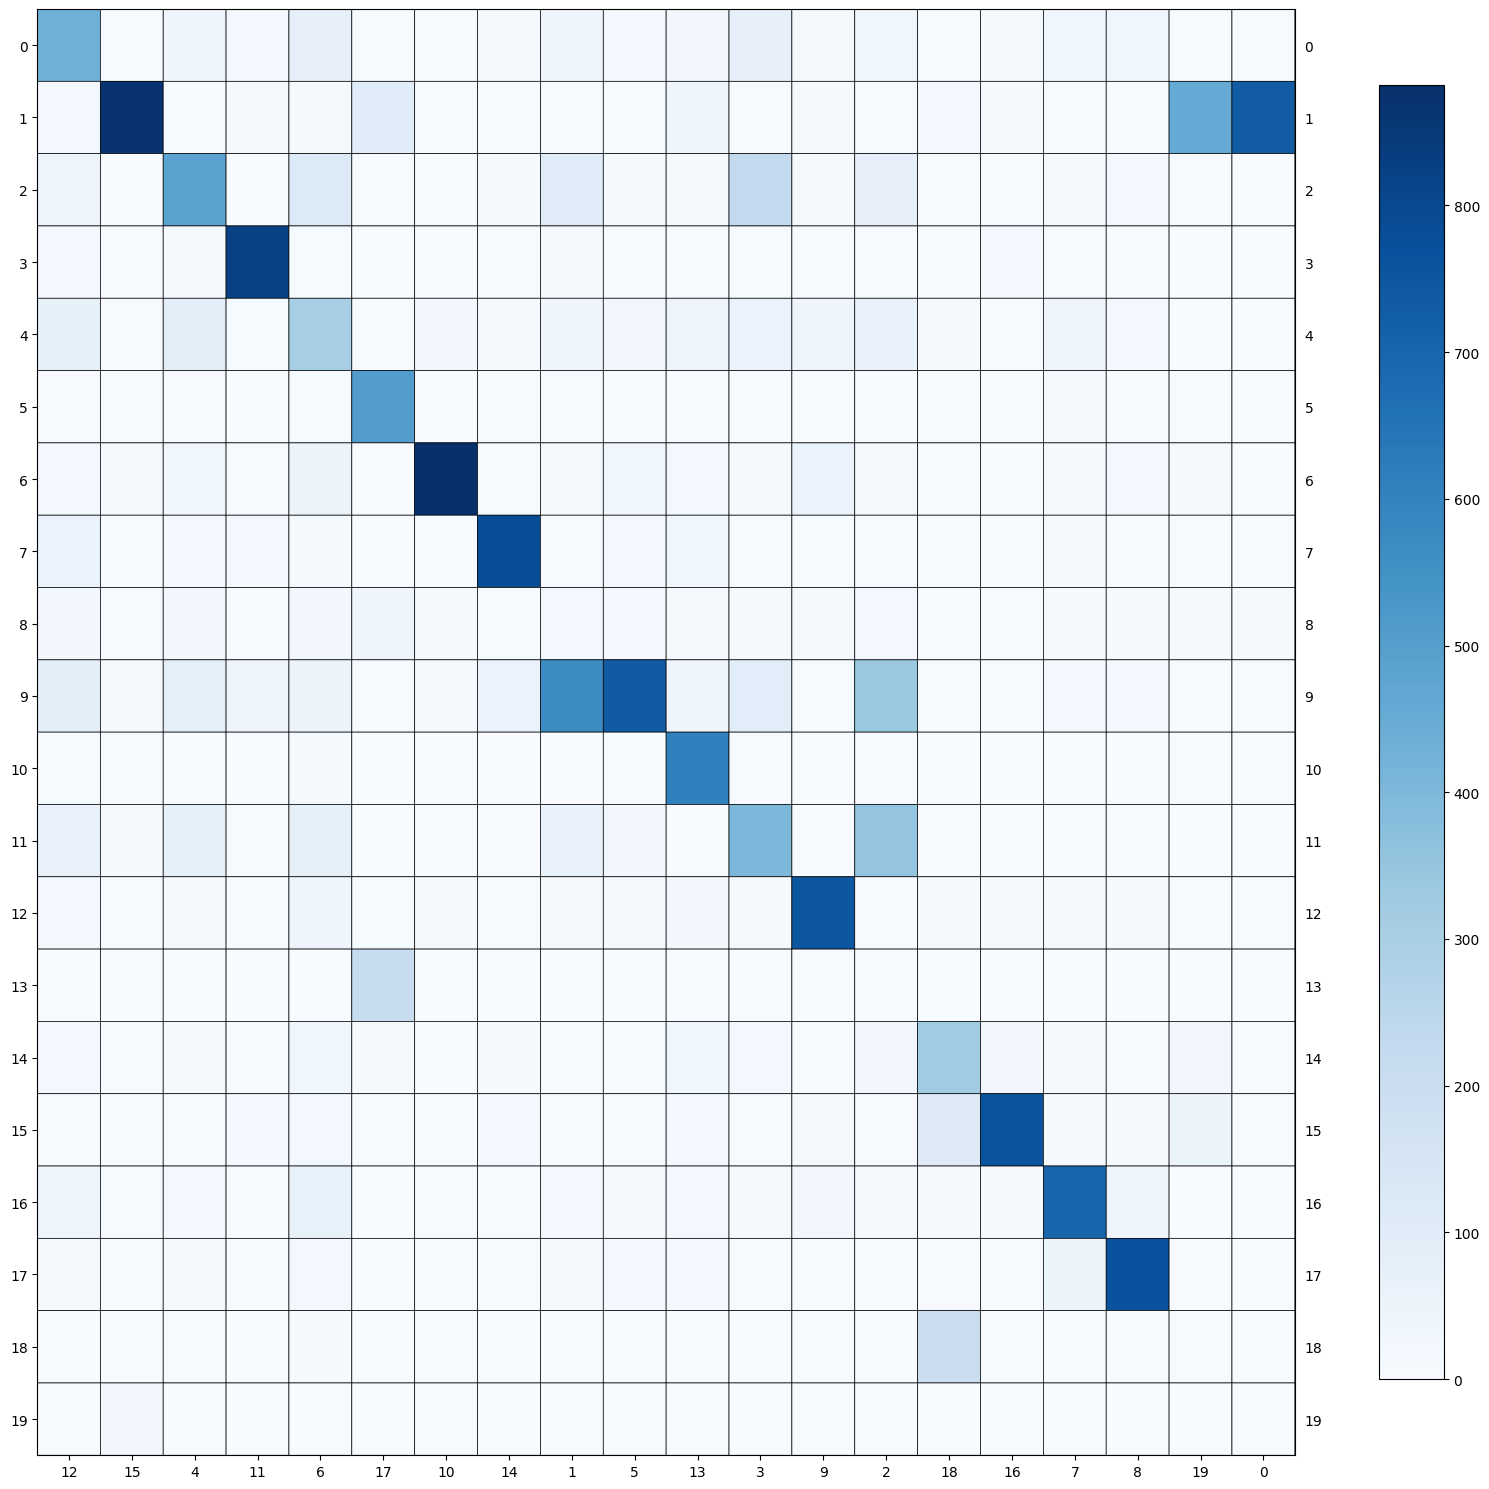

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


r = 200 , metric = euclidean
Homogeneity: 0.5017303461161797
Completeness: 0.5277920732676815
V-measure: 0.514431341391187
Adjusted Rand Index: 0.4066599777640225
Adjusted Mutual Information: 0.5127957532312868
Confusion Matrix for r = 200  and metric = euclidean


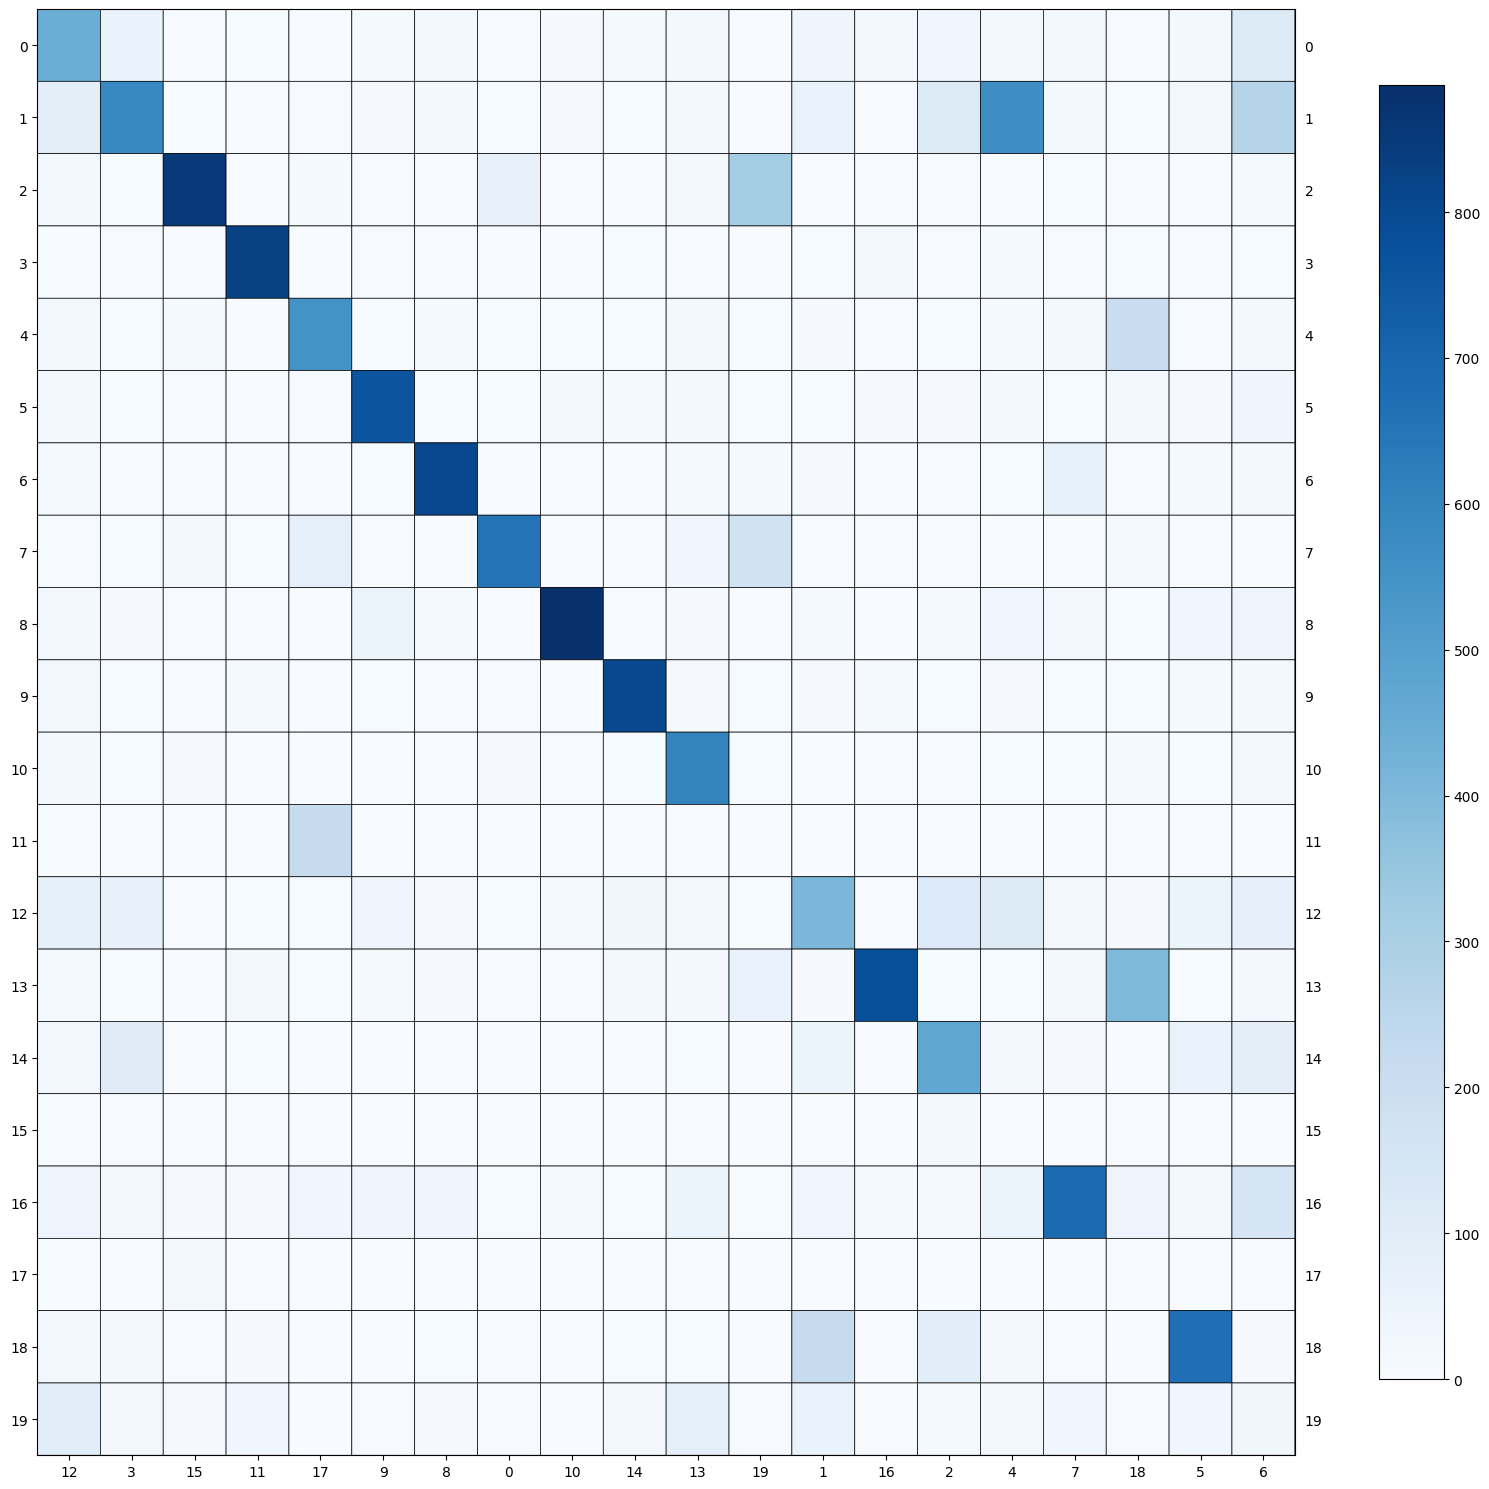

In [19]:
# Settings for UMAP
n_components = [5, 20, 200]
metrics_list = ['cosine', 'euclidean']

# Iterate over each setting
# Takes about 15 minutes
# Random_state may be foregone to make use of more cores while getting nearly identical results
for r in n_components:
  for metric in metrics_list:
    reducer = umap.UMAP(n_components = r, metric = metric, random_state = 0)
    embedding = reducer.fit_transform(X_tfidf)

    # Fit
    kmeans.fit(embedding)

    # Get labels for each data point
    labels = kmeans.labels_

    # Get metrics
    homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
    completeness = metrics.completeness_score(newsgroups_labels, labels)
    v_measure = metrics.v_measure_score(newsgroups_labels, labels)
    ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
    ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

    # Print metrics
    print("r =", r, ", metric =", metric)
    print("Homogeneity:", homogeneity)
    print("Completeness:", completeness)
    print("V-measure:", v_measure)
    print("Adjusted Rand Index:", ari)
    print("Adjusted Mutual Information:", ami)

    # Plot confusion matrix
    print("Confusion Matrix for r =", r, " and metric =", metric)
    cm = confusion_matrix(labels, newsgroups_labels)
    rows, cols = linear_sum_assignment(cm, maximize = True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels = cols, yticklabels = rows, size = (15, 15), if_show_values = False)
    print()

### Question 12

TODO

### Question 13

TODO

### Question 14

In [ ]:
# Reduce data using UMAP
reducer = umap.UMAP(n_components = 20, metric = metric, random_state = 0)
embedding = reducer.fit_transform(X_tfidf)

In [26]:
# Running both fits takes about a minute to run total
# Perform agglomerative clustering with 20 clusters and ward linkage
agglomerative = AgglomerativeClustering(n_clusters = 20, linkage = 'ward')
agglomerative.fit(embedding)

# Get labels for each data point
labels = agglomerative.labels_

# Get metrics
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
completeness = metrics.completeness_score(newsgroups_labels, labels)
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

# Print metrics
print("Agglomerative clustering with ward linkage:")
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)
print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)
print()

# Perform agglomerative clustering with 20 clusters and single linkage
agglomerative = AgglomerativeClustering(n_clusters = 20, linkage = 'single')
agglomerative.fit(embedding)

# Get labels for each data point
labels = agglomerative.labels_

# Get metrics
homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
completeness = metrics.completeness_score(newsgroups_labels, labels)
v_measure = metrics.v_measure_score(newsgroups_labels, labels)
ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

# Print metrics
print("Agglomerative clustering with single linkage:")
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)
print("Adjusted Rand Index:", ari)
print("Adjusted Mutual Information:", ami)

Agglomerative clustering with ward linkage:
Homogeneity: 0.474244709554062
Completeness: 0.5296268998240177
V-measure: 0.500408125765538
Adjusted Rand Index: 0.3496197976182979
Adjusted Mutual Information: 0.4986675422139647

Agglomerative clustering with single linkage:
Homogeneity: 0.054101339450178594
Completeness: 0.41809869410937217
V-measure: 0.09580558138962894
Adjusted Rand Index: 0.006625680401787415
Adjusted Mutual Information: 0.09048752790240845


### Question 15

In [ ]:
# Reduce data using UMAP
reducer = umap.UMAP(n_components = 20, metric = metric, random_state = 0)
embedding = reducer.fit_transform(X_tfidf)

In [28]:
# Perform HDBSCAN clustering
# Takes about a 30-60s to run all three configurations
# TODO: Optional, but can adjust HDBSCAN parameters to improve performance
min_cluster_sizes = [20, 100, 200]

for min_cluster_size in min_cluster_sizes:
  hdbscan_cluster = HDBSCAN(min_cluster_size = min_cluster_size)
  hdbscan_cluster.fit(embedding)

  # Get labels for each data point
  labels = hdbscan_cluster.labels_

  # Get metrics
  homogeneity = metrics.homogeneity_score(newsgroups_labels, labels)
  completeness = metrics.completeness_score(newsgroups_labels, labels)
  v_measure = metrics.v_measure_score(newsgroups_labels, labels)
  ari = metrics.adjusted_rand_score(newsgroups_labels, labels)
  ami = metrics.adjusted_mutual_info_score(newsgroups_labels, labels)

  # Print metrics
  print("Agglomerative clustering with min_cluster_size = ", min_cluster_size)
  print("Homogeneity:", homogeneity)
  print("Completeness:", completeness)
  print("V-measure:", v_measure)
  print("Adjusted Rand Index:", ari)
  print("Adjusted Mutual Information:", ami)
  print()

Agglomerative clustering with min_cluster_size =  20
Homogeneity: 0.3910229639951682
Completeness: 0.3507663342373736
V-measure: 0.36980229294227546
Adjusted Rand Index: 0.033659363131048066
Adjusted Mutual Information: 0.3469756184646917

Agglomerative clustering with min_cluster_size =  100
Homogeneity: 0.014016932096549901
Completeness: 0.46179206103039716
V-measure: 0.027208010170845662
Adjusted Rand Index: 0.0006366463388907458
Adjusted Mutual Information: 0.026542611245880966

Agglomerative clustering with min_cluster_size =  200
Homogeneity: 0.014016932096549901
Completeness: 0.46179206103039716
V-measure: 0.027208010170845662
Adjusted Rand Index: 0.0006366463388907458
Adjusted Mutual Information: 0.026542611245880966



### Question 16

In [29]:
# Reduce data using UMAP
reducer = umap.UMAP(n_components = 20, metric = metric, random_state = 0)
embedding = reducer.fit_transform(X_tfidf)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Confusion matrix for HDBSCAN with min_cluster_size = 20


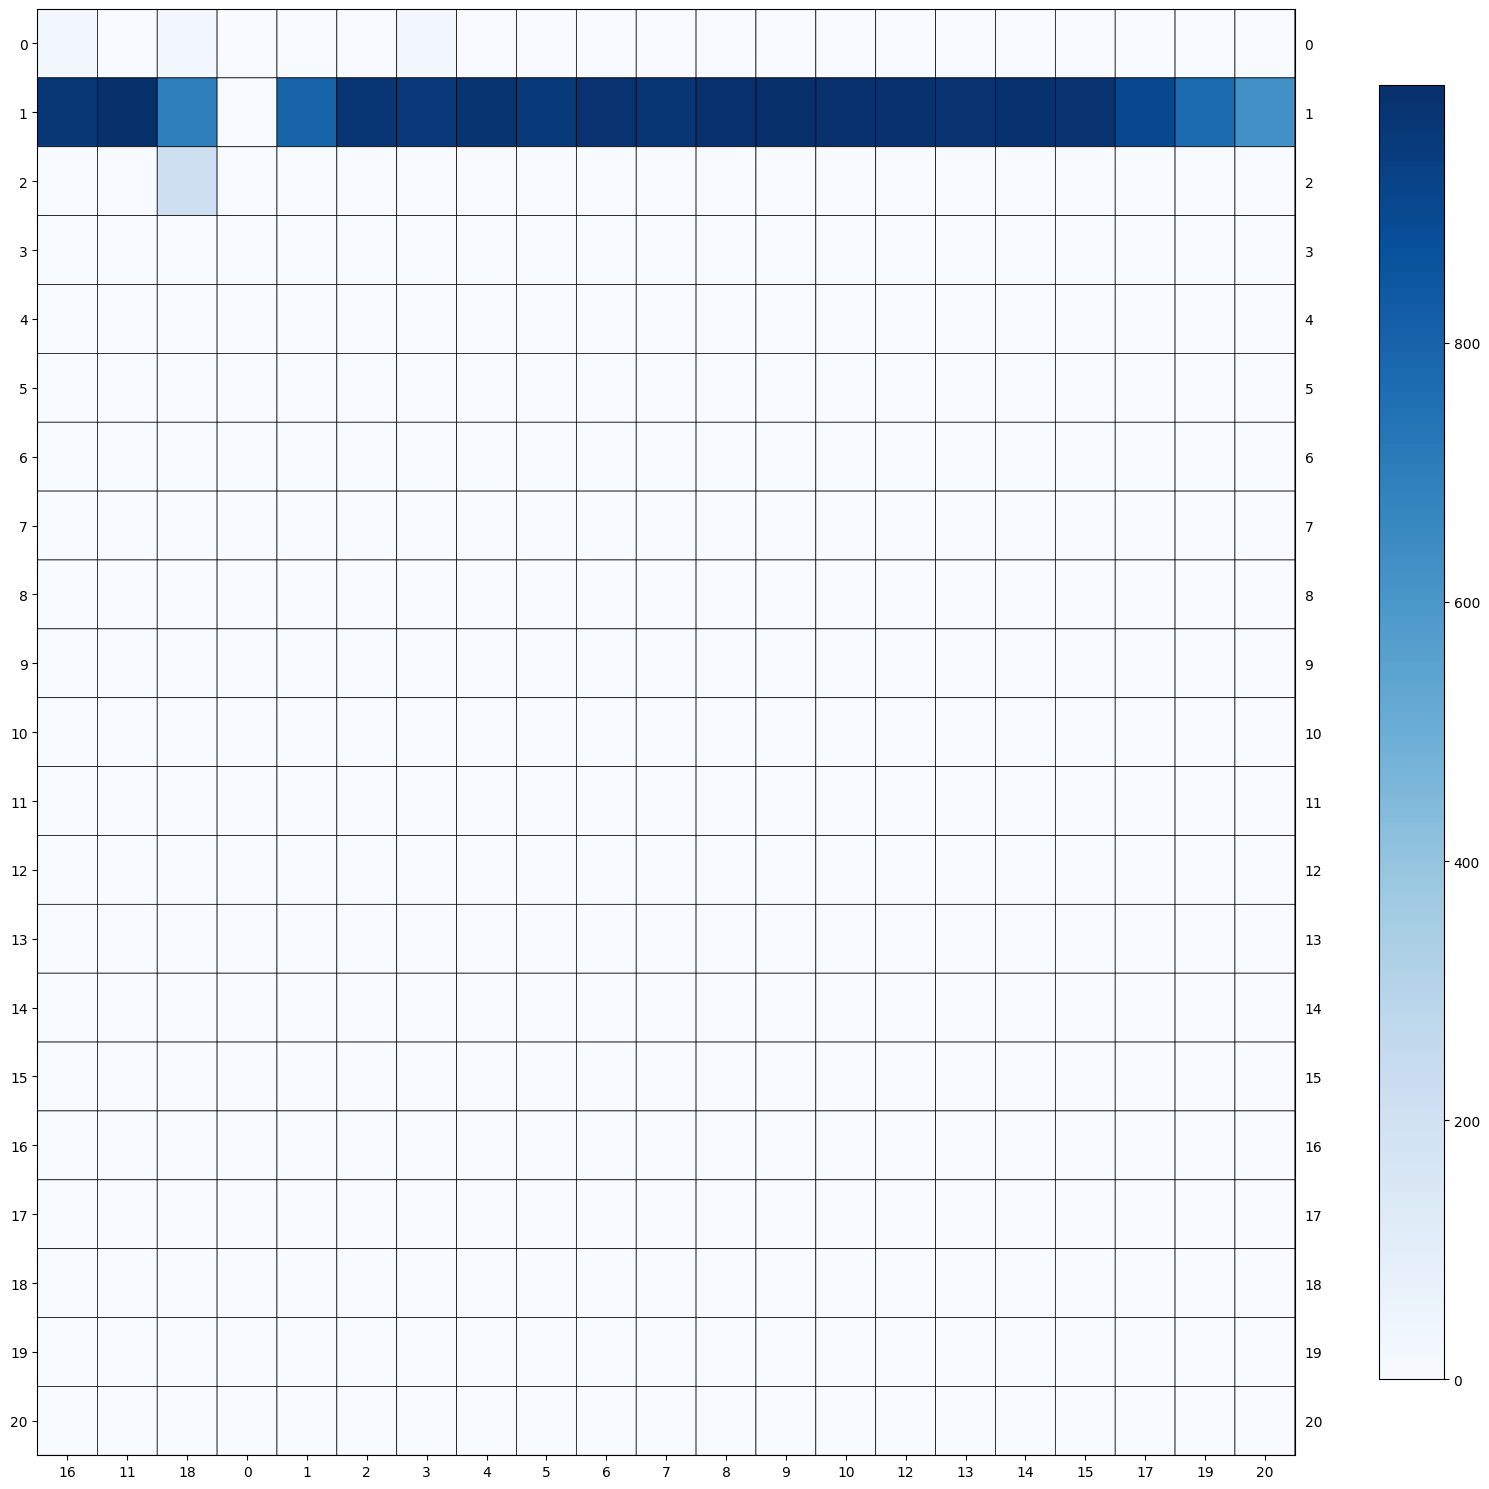

In [30]:
# From question 15, best configuration is where min_cluster_size = 20
hdbscan_cluster = HDBSCAN(min_cluster_size = min_cluster_size)
hdbscan_cluster.fit(embedding)

# Get labels for each data point
labels = hdbscan_cluster.labels_

# Plot confusion matrix
print("Confusion matrix for HDBSCAN with min_cluster_size = 20")
cm = confusion_matrix(labels, newsgroups_labels)
rows, cols = linear_sum_assignment(cm, maximize = True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels = cols, yticklabels = rows, size = (15, 15), if_show_values = False)
print()

# TODO: Ask TA about confusion matrix as there are only 2 clusters

In [35]:
print(np.unique(labels)) # Looks like everything in one of two clusters or an outlier

# Get counts of each label
label_counts = np.unique(labels, return_counts = True)
print(label_counts)


[-1  0  1]
(array([-1,  0,  1]), array([   77, 18546,   223]))


A label of -1 suggests that the sample is noisy or an outlier.